# GUI Testing

In this chapter, we explore how to generate tests for Graphical User Interfaces (GUIs), abstracting from our [previous examples on Web testing](WebFuzzer.ipynb).  Building on general means to extract user interface elements and to activate them, our techniques generalize to arbitrary graphical user interfaces, from rich Web applications to mobile apps.

**Prerequisites**

* We build on the Web server introduced in the [chapter on Web testing](WebFuzzer.ipynb).

## Automated GUI Interaction

How can we automate interaction?

### Our Web Server, Again

We (again) run our Web server.

In [1]:
import fuzzingbook_utils

In [2]:
from WebFuzzer import BetterHTTPRequestHandler, run_httpd, webbrowser, print_httpd_messages
from WebFuzzer import HTTPD_MESSAGE_QUEUE, ORDERS_DB

In [3]:
from multiprocessing import Queue, Process

In [4]:
httpd_process = Process(target=run_httpd, args=(BetterHTTPRequestHandler,))
httpd_process.start()

In [5]:
httpd_url = HTTPD_MESSAGE_QUEUE.get()

In [6]:
from IPython.core.display import HTML, display, Image

In [7]:
HTML(webbrowser(httpd_url))

### Remote Control with Selenium

Let us just look at the GUI, above.  We do not assume we can access the HTML source, or even the URL of the current page.  All we assume is that there is a set of *user interface elements* we can interact with.

Documentation is available [here.](https://selenium-python.readthedocs.io/index.html)

In [8]:
from selenium import webdriver

In [9]:
from selenium.webdriver.common.keys import Keys

In [10]:
# Variant 2: Firefox

In [11]:
from selenium.webdriver.firefox.options import Options

In [12]:
options = Options()
options.headless = True
driver = webdriver.Firefox(options=options)

In [13]:
# Alternative: Chrome

# options = webdriver.ChromeOptions()
# options.add_argument('headless')
# options.add_argument('window-size=700x230')
# driver = webdriver.Chrome(options=options)

In [14]:
driver.get(httpd_url)

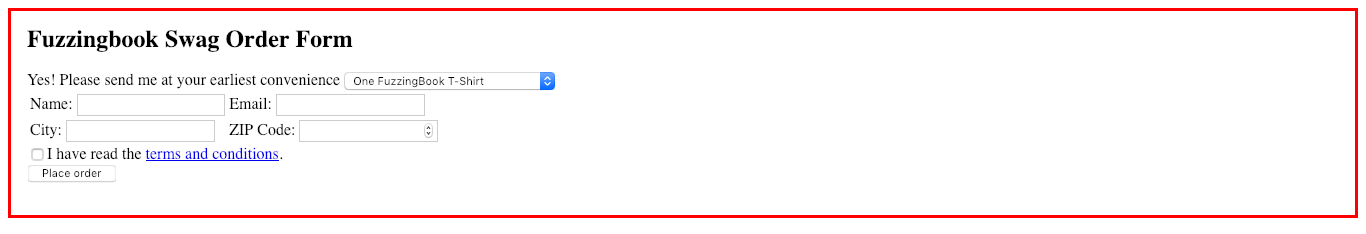

In [15]:
Image(driver.get_screenshot_as_png())

In [16]:
name = driver.find_element_by_name('name')
name.send_keys("Jane Doe")

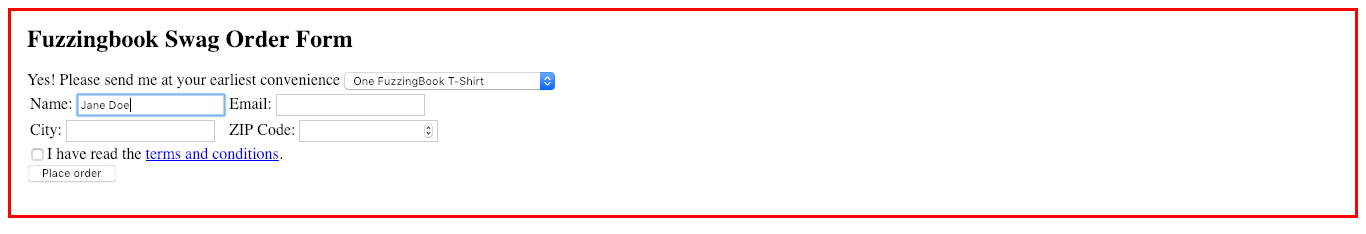

In [17]:
Image(driver.get_screenshot_as_png())

In [18]:
email = driver.find_element_by_name('email')
email.send_keys("j.doe@example.com")

In [19]:
city = driver.find_element_by_name('city')
city.send_keys("Seattle")

In [20]:
zip = driver.find_element_by_name('zip')
zip.send_keys("98104")

In [21]:
terms = driver.find_element_by_name('terms')
terms.click()

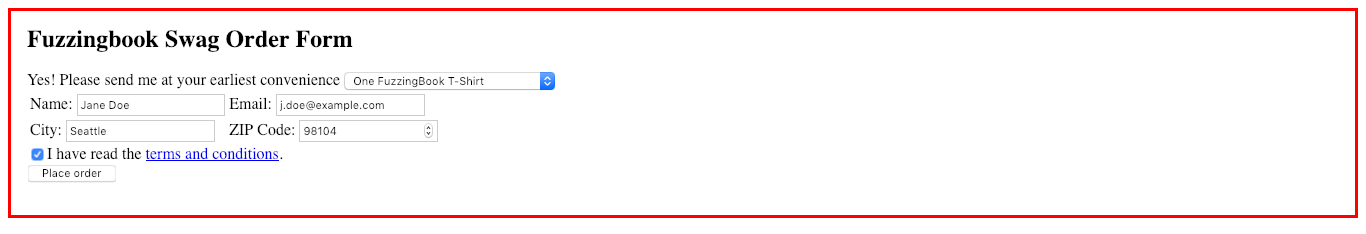

In [22]:
Image(driver.get_screenshot_as_png())

In [23]:
submit = driver.find_element_by_name('submit')
submit.click()

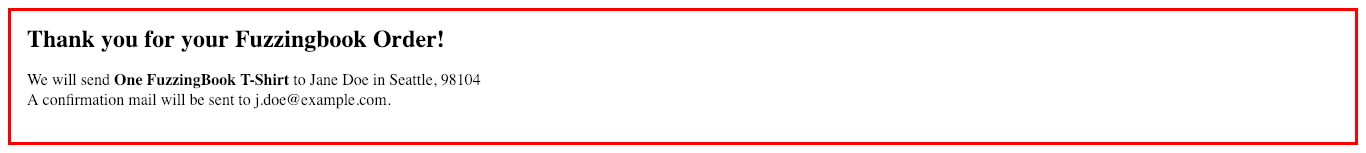

In [24]:
Image(driver.get_screenshot_as_png())

In [25]:
print_httpd_messages()

## Retrieving UI Elements

In [26]:
driver.get(httpd_url)

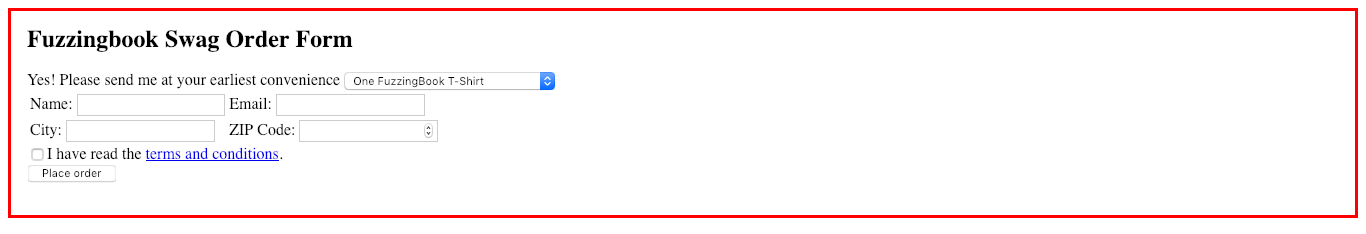

In [27]:
Image(driver.get_screenshot_as_png())

In [28]:
ui_elements = driver.find_elements_by_tag_name("input")

In [29]:
for element in ui_elements:
    print(element.get_attribute('name'), element.get_attribute('type'), element.text)

name text 
email email 
city text 
zip number 
terms checkbox 


In [30]:
ui_elements = driver.find_elements_by_tag_name("button")

In [31]:
for element in ui_elements:
    print(element.get_attribute('name'), element.get_attribute('type'), element.text)

submit submit Place order


\todo{Use a grammar to fill out a set of fields, generating a sequence of calls}

```python
name.click()
city.send_keys("foo")
```

## Systematic GUI Exploration

In [32]:
links = driver.find_elements_by_tag_name("a")

In [33]:
links[0].get_attribute('href')

'http://127.0.0.1:8800/terms'

In [34]:
links[0].click()

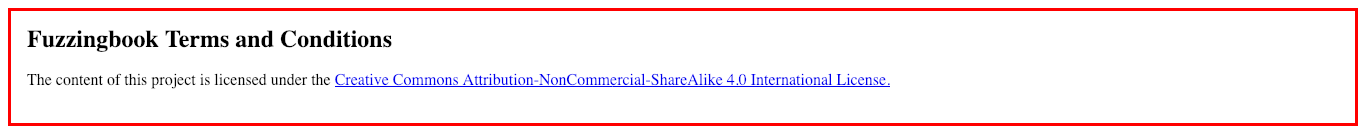

In [35]:
Image(driver.get_screenshot_as_png())

In [36]:
driver.back()

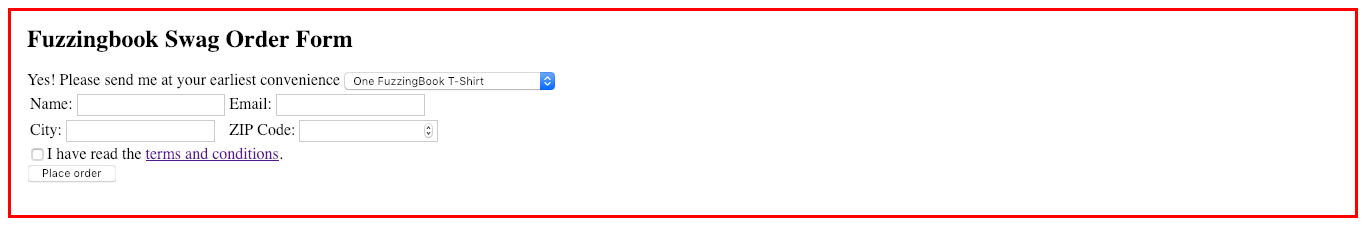

In [37]:
Image(driver.get_screenshot_as_png())

\todo{Click on all links, exploring one page after another}

\todo{Create a finite state automaton}

\todo{Convert it into a grammar and traverse all paths}

## Fun with FuzzingBook

\todo{Create a full map of fuzzingbook.org, only by navigating}

In [38]:
driver.get("https://www.fuzzingbook.org/")

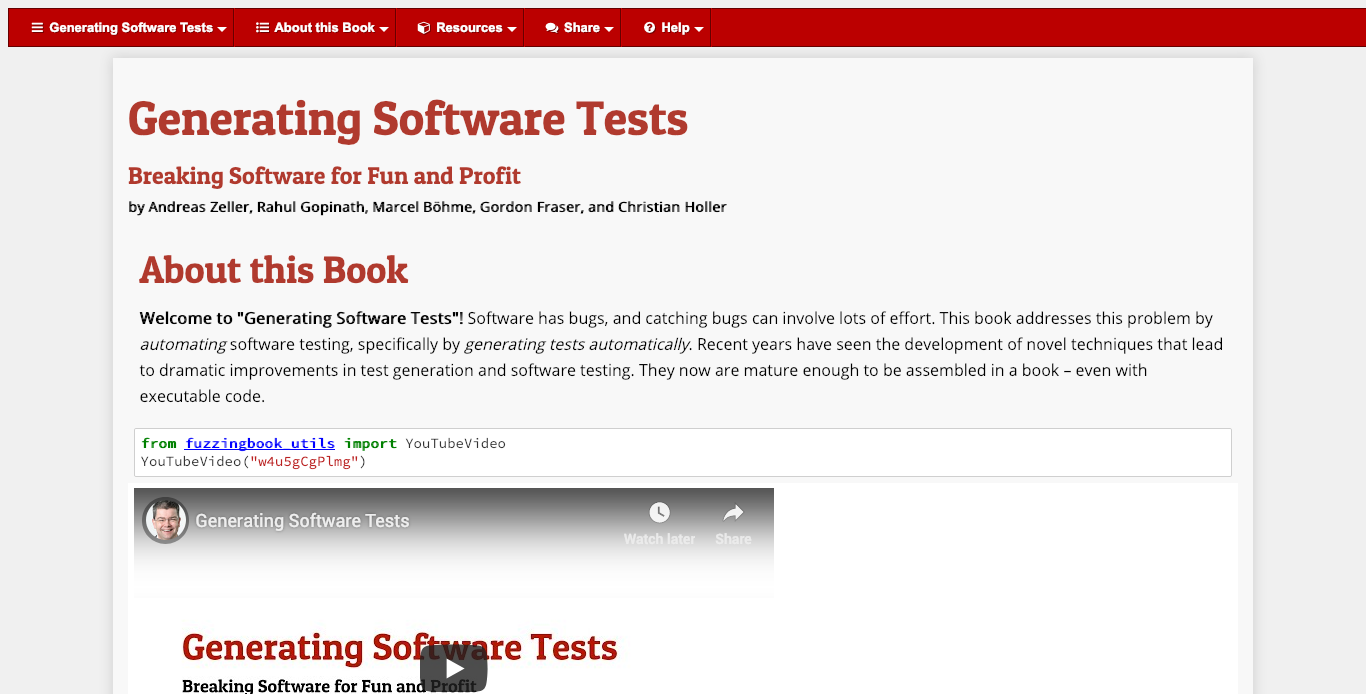

In [39]:
Image(driver.get_screenshot_as_png())

In [40]:
links = driver.find_elements_by_tag_name("a")

That's it – we're done!

In [41]:
driver.quit()

In [42]:
httpd_process.terminate()

In [43]:
import os

In [44]:
for temp_file in [ORDERS_DB, "geckodriver.log", "ghostdriver.log"]:
    if os.path.exists(temp_file):
        os.remove(temp_file)

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```markdown
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [45]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [46]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_